In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

Other potential data sources:

Somewhat irregularly collected data from Georgia universities
https://docs.google.com/document/d/1tCijdezYBswB6fjFZcLPxalbRBolAR9DDOLjBjc-oaM/edit
        
SUNY maintains one dashboard for all 64 campuses.  maybe we can scrape it?
https://www.suny.edu/covid19-tracker/

Before running this, do a git pull on `../../college-covid19-dataset` (the big10 repo)

In [18]:
nyt_datapath = '../UniversityCases/'
big10_datapath = '../../college-covid19-dataset/data'

### Import and Clean Data

New York Times - All Schools

In [19]:
fnames = sorted(glob.glob(nyt_datapath+'*.csv'))
frames = []
for f in fnames:
    m = re.search(r'[^0-9]*([0-9][0-9_]+)[^0-9]*', f)
    df = pd.read_csv(f)
    df['Date'] = pd.to_datetime(m.group(1), format='%m_%d_%y')
    df.drop(['Unnamed: 0'], axis = 1, inplace=True)
    df['Cases'] = df['Cases'].apply(lambda x: x.replace(',', '')).astype('int')
    frames.append(df)

In [20]:
nyt_df = pd.concat(frames)
nyt_df.index = pd.MultiIndex.from_frame(nyt_df[['School', 'Date']])
nyt_df.drop(['School', 'Date'], axis = 1, inplace = True)

Big 10 - All dates

Data source: https://91-divoc.com/pages/covid-19-at-big-ten-conference-schools/

Note that this reports ALL cases among students, faculty, and staff (added together)

In [21]:
big10_df = pd.read_csv(big10_datapath + '/daily.csv')
old_cols = big10_df.columns.values.copy()
old_cols[0] = 'School'
big10_df.columns = old_cols
big10_df['Date'] = pd.to_datetime(big10_df['Date'],format='%Y-%m-%d')

In [22]:
big10_df.index = pd.MultiIndex.from_frame(big10_df[['School', 'Date']])
big10_df.drop(['School', 'Date'], axis = 1, inplace = True)

MTurk Data for one day - 11/20/2020

In [85]:
turk_df = pd.read_csv('../MTurk_Data/turk11_19_2020.csv')
turk_df['Date'] = pd.to_datetime('2020-11-19',format='%Y-%m-%d')
Cases = turk_df['CumulativeCases'].copy()
Cases[turk_df['CumulativeCases'] == 'No agreed upon value'] = np.nan
turk_df['CumulativeCases'] = Cases.astype('float')
turk_df.index = pd.MultiIndex.from_frame(turk_df[['SchoolName', 'Date']])
turk_df.drop(['SchoolName', 'Unnamed: 0', 'Date'], axis = 1, inplace = True)

The next process drops all repeated data -- only keeps values that are different from the day before

In [25]:
# there is probably a much faster way to do this
# currently this takes a lot of time as it operates on each school separately
for df, test_col in [(big10_df, 'Confirmed'), (nyt_df, 'Cases')]:
    for School in df.index.levels[0]:
        msmts = df.loc[School]
        msmt_dates = msmts.index
        unchanged_dates = msmt_dates[(msmts.shift(1) == msmts)[test_col]]
        if len(unchanged_dates):
            unchanged_entries = zip(len(unchanged_dates) * [School], unchanged_dates)
            df.drop(unchanged_entries, axis = 0, inplace = True)

### Inspect Data

In [96]:
turk_df.shape

(171, 7)

In [90]:
big10_df.shape

(768, 2)

In [91]:
nyt_df.shape

(8931, 6)

In [92]:
turk_df.head()

,,LastUpdate,LastUpdateAgreed,CumulativeCases,CumulativeCasesAgreed,TotalTests,TotalTestsAgreed,TotalResponses
SchoolName,Date,,,,,,,
American University,2020-11-19,2020-11-16 00:00:00,5.0,35.0,5.0,No agreed upon value,NaN,5.0
Auburn University,2020-11-19,2020-11-15 00:00:00,4.0,1467.0,4.0,No agreed upon value,NaN,5.0
Augustana College,2020-11-19,NaN,NaN,NaN,NaN,No agreed upon value,NaN,3.0
Ball State University,2020-11-19,NaN,NaN,1283.0,3.0,2767,2.0,5.0
Bard College,2020-11-19,2020-11-13 00:00:00,5.0,1.0,4.0,6194,5.0,5.0


In [93]:
big10_df.head()

Tests  Confirmed
School       Date                        
Michigan     2020-03-14   41.0          7
             2020-03-15  409.0         41
Northwestern 2020-03-19    NaN          7
Michigan     2020-03-22  662.0         81
Northwestern 2020-03-27    NaN          8

In [94]:
nyt_df.head()

,,Cases,County_Active_Cases,County_Total_Cases,City,County,State
School,Date,,,,,,
Alabama A&M University,2020-09-08,8,6574.0,6631.0,Huntsville,Madison,Alabama
Athens State University,2020-09-08,2,1697.0,1715.0,Athens,Limestone,Alabama
Auburn University*,2020-09-08,1074,3480.0,3529.0,Auburn,Lee,Alabama
Auburn University at Montgomery,2020-09-08,2,7800.0,7963.0,Montgomery,Montgomery,Alabama
Jacksonville State University,2020-09-08,219,2571.0,2602.0,Jacksonville,Calhoun,Alabama


big10 is reporting (students + employees), on campus.   NYT is reporting students, on and off campus.

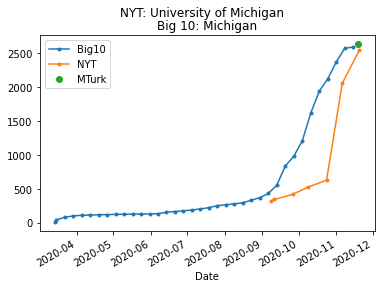

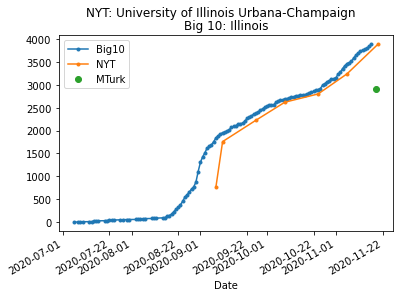

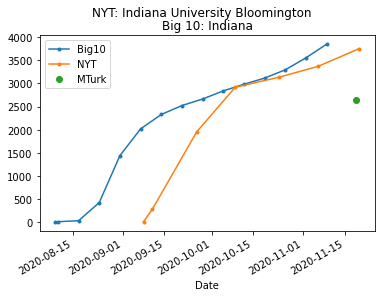

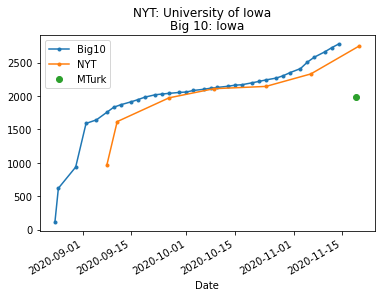

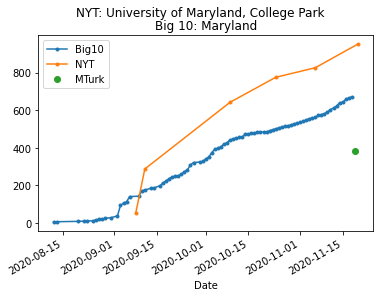

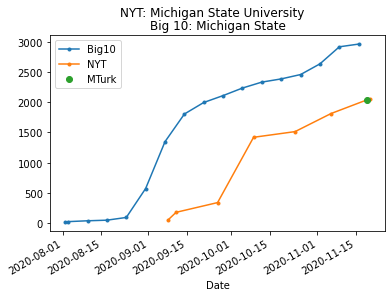

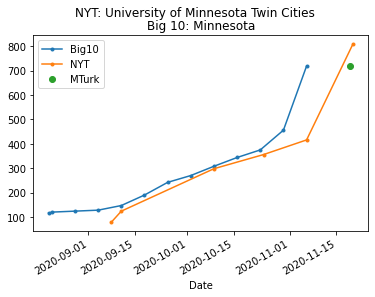

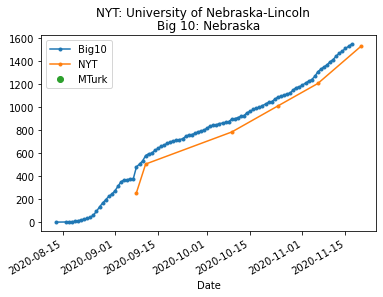

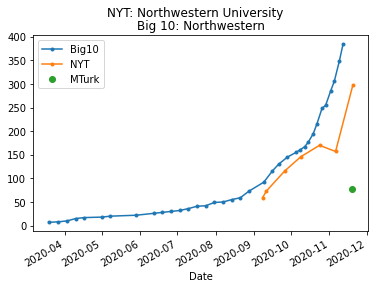

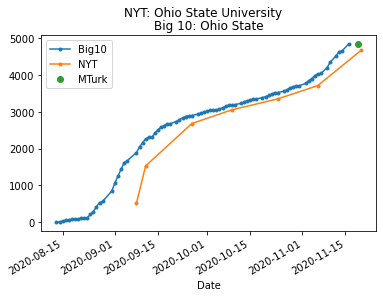

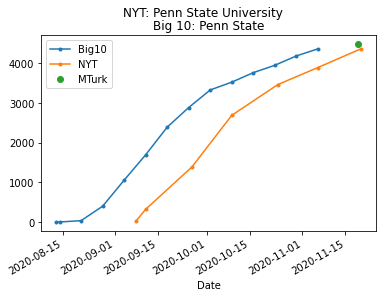

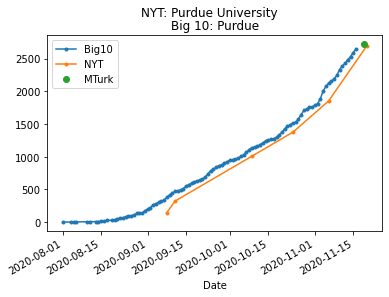

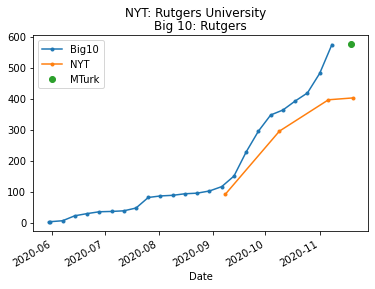

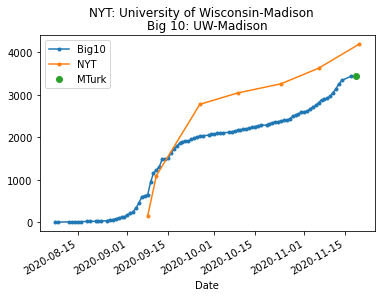

In [95]:
for b10_name, nyt_name, turk_name in [('Michigan', 'University of Michigan', 'University of Michigan'), 
                           ('Illinois', 'University of Illinois Urbana-Champaign', 'University of Illinois Urbana Champaign '),
                           ('Indiana', 'Indiana University Bloomington', 'Indiana University'),
                           ('Iowa', 'University of Iowa', 'University of Iowa'),
                           ('Maryland', 'University of Maryland, College Park', 'University of Maryland'),
                           ('Michigan State', 'Michigan State University', 'Michigan State University'),
                           ('Minnesota', 'University of Minnesota Twin Cities', 'University of Minnesota'),
                           ('Nebraska', 'University of Nebraska-Lincoln', 'University of Nebraska-Lincoln'),
                           ('Northwestern', 'Northwestern University', 'Northwestern University'),
                           ('Ohio State', 'Ohio State University', 'Ohio State University'),
                           ('Penn State', 'Penn State University', 'Penn State University'),
                           ('Purdue', 'Purdue University', 'Purdue University'),
                           ('Rutgers', 'Rutgers University', 'Rutgers University'),
                           ('UW-Madison', 'University of Wisconsin-Madison', 'University of Wisconsin Madison')]:
    fig, ax = plt.subplots(1)
    big10_df.loc[b10_name]['Confirmed'].plot(style = '.-', ax = ax, label = 'Big10')
    nyt_df.loc[nyt_name]['Cases'].plot(style = '.-', ax = ax, label = 'NYT')
    turk_df.loc[turk_name]['CumulativeCases'].plot(style = 'o', ax = ax, label = 'MTurk')
    plt.suptitle('NYT: {}'.format(nyt_name))
    plt.title('Big 10: {}'.format(b10_name))
    plt.legend(loc = 'best')